# E3. 고양이수염 스티커 붙이기

## 1. 사진 준비

### (1) 작업할 디렉토리 만들기

```javascript
$ mkdir -p ~/aiffel/camera_sticker/models
$ mkdir -p ~/aiffel/camera_sticker/images
```

### (2) 이미지 디렉토리에 작업할 image.jpg 파일 저장

### (3) 작업에 스티커로 쓰일 고양이수염 이미지 저장

### (4) 이미지 처리 관련 패키지 설치 (opencv, cmake, dlib)

```javascript
$ pip install opencv-python
$ pip install cmake
$ pip install dlib
```

### (5) 설치한 모듈들을 불러와서 준비한 이미지 읽어보기

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


### (6) 이미지 크기 변경

* 편의상 원본 이미지의 비율에 맞게 축소 또는 확대 $\rightarrow$ opencv는 BGR(파녹빨, cf. RGB=빨녹파)을 사용하기 때문에 색상이 이상하게 출력됨

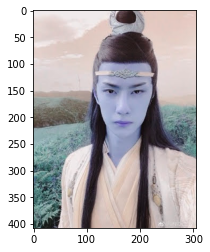

In [3]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 읽기
#img_bgr = cv2.resize(img_bgr, (640, 360))    # 원본사이즈가 306*408로 작아서 이 프로젝트에선 리사이즈 안 함
img_show = img_bgr.copy()      # 출력용 이미지 따로 보관
plt.imshow(img_bgr)
plt.show()

### (7) 색깔 보정처리

* opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하기 위한 작업

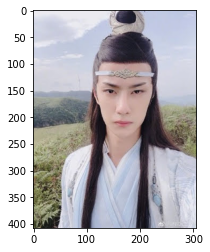

In [4]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것 잊지 말기!!!
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 face detection

* Object detection 기술을 이용하여 얼굴의 위치 찾기 (여기에선 공개된 패키지 사용)

* dlib의 face detector는 HOG(histogram of oriented gradient) feature를 사용하여 SVM(support vector machine)의 sliding window로 얼굴 찾음

### (1) dlib를 활용하여 hog detector 선언하기

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


### (2) detector를 이용하여 얼굴의 bounding box 추출하기

In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


* dlib는 rgb 이미지를 입력받기 때문에 `cvtClolr()`를 이용하여 opencv의 bgr 이미지를 rgb로 변환

* detector_hog의 두 번째 파라미터는 이미지 피라미드의 수

* (참고) 이미지 피라미드 : upsampling 방법을 통해 이미지의 크기를 키우는 것

### (3) 찾은 얼굴을 화면에 출력해보기

rectangles[[(115, 128) (223, 235)]]


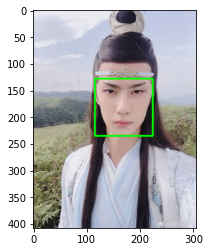

In [7]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* dlib detector는 `dlib.rectangles` 타입의 객체 반환

* `dlib.rectangles`는 `dlib.rectangle` 객체의 배열 형태로 이루어져 있음

* `dlib.rectangle`객체는 `left()`, `top()`, `right()`, `bottom()`, `height()`, `width()` 등의 멤버 함수를 포함 (dlib docs 참고)

* 주의 : 얼굴영역 나타내는 녹색박스가 정상적으로 출력되지 않는 경우, 본인의 사진을 이용하여 dlib를 통한 face detection이 정상적으로 진행되는지부터 체크

## 3. 얼굴 랜드마크 face landmark

* 스티커의 섬세한 적용을 위해 이목구비의 위치 파악 중요

* face landmark localization 기술 : 이목구비의 위치 추론

* 얼굴 랜드마크는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지 이용

###### Object keypoint estimation 알고리즘

* object keypoint estimation : Face landmark와 같이 객체 내부의 점을 찾는 기술

* keypoint 찾는 알고리즘 2가지
a) top-down : bounding box를 찾고 box 내부의 keypoint를 예측
b) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

* 이 예제에서는 a) 방식으로 진행

###### Dlib landmark localization

* 잘라진 얼굴 이미지에서 68개의 이목구비 위치 찾기 (데이터셋과 논문별로 차이 있음)

### (1) 공개된 weight file 다운로드

* 위치 : root디렉토리의 models디렉토리

```javascript
$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
$ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
```

### (2) 저장한 랜드마크 모델 불러오기

In [8]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


* `landmark_predictor`는 RGB 이미지와 `dlib.rectangle`을 입력받아 `dlib.full_object_detection`를 반환

### (3) `part()` 함수를 이용하여 개별 위치를 좌표 형태로 변환

In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


* points 는 `dlib.full_object_detection`의 객체이기 때문에 `parts()` 함수로 개별 위치에 접근 가능

* 즉, 직관적인 좌표(x,y) 좌표형태로 변환

* 그러면 `list_points`는 (x, y)-tuple 68개로 이루어진 리스트가 됨

* 이제, 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됨

### (4) 랜드마크를 영상에 출력하기

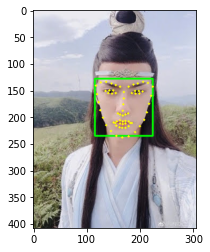

In [10]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기

* 스티커 위치와 스티커 크기 계산 필요

### (1) 좌표 확인

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(167, 188)
(x,y) : (167,134)
(w,h) : (109,109)


### (2) 준비한 스티커 이미지를 읽어서 적용하기

In [12]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(109, 109, 3)


* 고양이수염 스티커의 크기를 (1)에서 계산한 크기로 resize

### (3) 원본 이미지에 스티커 이미지를 추가하기 위해 (x,y) 좌표 조정

* 시작점이 top-left 좌표이기 때문

In [13]:
refined_x = x - w // 2  # left
refined_y = y - h      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (113,25)


* opencv 데이터는 numpy ndarray 형태의 데이터를 사용

* ndarray는 음수 인덱스에 접근할 수 없기 때문에 y값이 음수가 나온다면 예외 처리 필요

* y값이 음수일 때의 해결 : 원본 이미지의 범위를 벗어난 스티커 부분 제거

* -y 크기만큼 스티커 자르는 부분은 이 과정에서 불필요하다고 판단하여 삭제

### (4) top의 y좌표를 원본이미지의 경계값으로 수정하기

In [14]:
refined_y = 135
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (113,135)


### (5) 원본이미지에 스티커 적용하여 결과 이미지 출력하기

from PIL import Image, ImageOps,ImageFilter
def main():
    im=Image.open('cat_whiskers.png').covert(RGB)
    im_inv=ImageOps.invert(im)
    #im_inv.save('test.png')
    
    #Image boundary Gaussian blurring
    im_inv=im_inv.filter(ImageFilter.GaussianBlur(255.0))
    im_inv_L=im_inv.convert('L')
    #im_inv.save('test.png')
    
    im.putalpha(im_inv_L)
    im.save("cat_whiskers_trans.png","PNG")

* 위의 코드는 스티커 이미지 배경 투명화 하는 방법을 찾은 건데, 수염이 투명하게 바뀜... 뭐가 문제인지 모르겠음.
* 아래의 `np.where(img_sticker==0`에서 `np.where(img_sticker==255`로 바꾸면 해결되긴 하지만 다른 방법을 시도해보려고 위의 방법을 적용했으나 실패함)

In [15]:
sticker_area = img_show[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

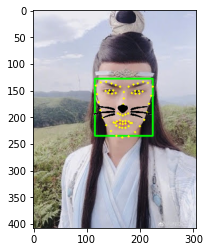

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* `sticker_area`는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지이므로 예제에서는 (566,0) 부터 (566+268, 0+157) 범위의 이미지를 의미

* 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용

* 따라서 `np.where`를 통해 `img_sticker` 가 0 인 부분은 `sticker_area`를 사용하고 0이 아닌 부분을 `img_sticker`를 사용

### (6) 경계박스와 랜드마크 제거하고 최종 결과물 출력하기

* 여기에선 `img_show` 대신 `img_rgb`를 활용

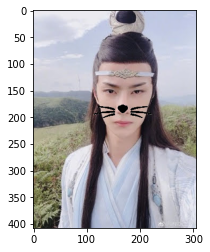

In [17]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 회고

얼굴 각도가 바닥과 수직이 아닌 사진을 이용했을 때 4-(1)의 좌표 설정에 회전변환식을 적용했으나, 스티커 적용이 안 되어서 좌표설정하는 문제는 다시 생각해 보려고 한다.